# Wind Climatology Maps

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import os
import errno
import pickle
from salishsea_tools import viz_tools, geo_tools, grid_tools, utilities
%matplotlib inline
speed_cmap = cmocean.cm.speed

In [2]:
GEM = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1")  # HDPRC latlon
nemo_mask =xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02") # NEMO land mask
nemo_grid = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02") # NEMO lat lon
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1") # Contains wind data

In [3]:
# Getting the wind data from the DAP server. Would recommend using the make-hdf5.py script to get the paths of the netcdf files and loop through the files.
wind_u = winddata.u_wind.loc[winddata['time.year'].isin([2015, 2016, 2017, 2018])]
wind_v = winddata.v_wind.loc[winddata['time.year'].isin([2015, 2016, 2017, 2018])]

In [ ]:
# build the land mask for the GEM grid. I have saved this as a pickle file /ocean/abhudia/MEOPAR/analysis-ashutosh/GEM_mask.pickle so no need to recompute.

def build_GEM_mask(grid_GEM, grid_NEMO, mask_NEMO):


    # Preallocate
    ngrid_GEM = grid_GEM['gridX'].shape[0] * grid_GEM['gridY'].shape[0]
    mask_GEM = np.zeros(ngrid_GEM, dtype=int)

    # Evaluate each point on GEM grid
    bar = utilities.statusbar('Building GEM mask', width=90, maxval=ngrid_GEM)
    for index, coords in enumerate(bar(zip(
            grid_GEM['longitude'].values.reshape(ngrid_GEM) - 360,
            grid_GEM['latitude'].values.reshape(ngrid_GEM),
    ))):

        j, i = geo_tools.find_closest_model_point(
            coords[0], coords[1],
            grid_NEMO['longitude'], grid_NEMO['latitude'],
        )
        if j is np.nan or i is np.nan:
            mask_GEM[index] = 0
        else:
            mask_GEM[index] = mask_NEMO[j, i].values

    # Reshape
    mask_GEM = mask_GEM.reshape(grid_GEM['longitude'].shape)

    return mask_GEM

In [ ]:
land_mask = build_GEM_mask(GEM, nemo_grid, nemo_mask.tmaskutil.isel(time=0)) 

In [4]:
# Loading land mask from file
openpickle = open("GEM_mask.pickle" , 'rb') 
land_mask = pickle.load(openpickle)

In [5]:
def mask_data(data, land_mask = land_mask):
    """Output a masked array containing only the domain of SalishSeacast
    """
    masked_data = ma.masked_array(data, np.logical_not(land_mask))  # mask the data
    # The following part removes the zero rows and so produces only the parts which are in the SSC domain.
    remove_zero_rows = masked_data[~(masked_data==np.nan).all(1)]   # remove rows with only zero entries
    transpose_rows = np.transpose(remove_zero_rows)                 # transpose the resulting array
    remove_zero_cols = np.transpose(transpose_rows[~(transpose_rows==np.nan).all(1)])  # remove the column with only zero entries
    return remove_zero_cols

In [6]:
# contour mask
def make_contour_mask():
    """Output a contour mask for plotting land mask and coastline
    """
    masked_data = land_mask
    remove_zero_rows = masked_data[~(masked_data==0).all(1)]   # remove rows with only zero entries
    transpose_rows = np.transpose(remove_zero_rows)                 # transpose the resulting array
    remove_zero_cols = np.transpose(transpose_rows[~(transpose_rows==0).all(1)])  # remove the column with only zero entries
    return remove_zero_cols

In [7]:
contour_mask = make_contour_mask()

## Computing all wind magnitudes

In [ ]:
## import data as dictionary

In [ ]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
# data sets by month
monthly_data = {}
bar = utilities.statusbar('loading', maxval=12)
for month, abbr in bar(zip(range(1,13) , abbrs)):
    monthly_data.update({abbr+'_data' :  xr.ufuncs.sqrt(wind_u.loc[wind_u['time.month'].isin([month])]**2 + wind_v.loc[wind_v['time.month'].isin([month])]**2)})

## Function Definition

In [ ]:
names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbr = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
operation_names = ['Mean', 'Standard Deviation', 'Maxima']
operations = ['mean', 'std', 'max']
thresholds = [5,10]

def produce_plots(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder='all_data', colormap='Reds'):
    # listofString listofString listofString listofNumber Integer Integer String String
    # produce pdf plots of data by operation and as percentage of datasets that exceed threshold
    # datasets as dictionary
    # abbr must contain prefixes of dictionary keys {}_data
    
    
    # plot data with applied xarray operations

    for operation in np.arange(len(operations)):
        fig = plt.figure()
        fig.set_size_inches(11.69, 8.27)
        overall_min = False
        overall_max = 0
        
        for time_period in range(len(names)): # time_period is month index
            array = getattr(dictionary_data[abbr[time_period] + '_data'], operations[operation])(**{'axis': 0}).values # get data and apply operation
            locals()[abbr[time_period] + '_temp'] = mask_data(array) # mask array
            
            # find universal minimum and maximum values for colorbar normalisation
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])  
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max

        # produce subplots       
        for time_period in range(len(names)):
            ax = plt.subplot(rows,cols,time_period+1)
            plt.pcolormesh(locals()[abbr[time_period] + '_temp'], vmin = overall_min, vmax = overall_max, cmap = colormap)
            plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
            plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
            viz_tools.set_aspect(ax)
            plt.title(names[time_period])
            if time_period is not 6:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            if time_period == 6:
                plt.xlabel('X')
                plt.ylabel('Y')
        
        # adjust and save plots as .pdf
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        figtitle = '{} of wind speeds 2015-2018 (m/s)'.format(operation_names[operation])
        fig.suptitle(figtitle, fontsize  =  18)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([overall_min,overall_max])), cmap = colormap), cax=cbar_ax)
        filename = '{}/{}_winds.pdf'.format(folder,operations[operation])
        if not os.path.exists(os.path.dirname(filename)):
            try:
                os.makedirs(os.path.dirname(filename))
            except OSError as exc:
                if exc.errno != errno.EEXIST:
                    raise
        plt.savefig(filename, bbox_inches = 'tight')
    
    # plot data with threshold percentages
    for threshold in thresholds:
        fig = plt.figure()
        fig.set_size_inches(11.69, 8.27)
        overall_min = False
        overall_max = 0
        
        for time_period in np.arange(len(names)): # time_periods is month index
            
            # count over all grids instances of threshold being exceeded
            time_steps = dictionary_data[abbr[time_period] + '_data'].time.size
            percentdata = dictionary_data[abbr[time_period] + '_data'].values
            condlist = [percentdata > threshold, percentdata <= threshold] 
            choicelist = [1, 0]
            locals()[abbr[time_period] + '_temp'] = mask_data(np.sum(np.select(condlist, choicelist), axis = 0) / time_steps * 100)
            
            # universal minima and maxima for colorbar normalisation 
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max
                
        # produce subplots       
        for time_period in range(len(names)):
            ax = plt.subplot(rows,cols,time_period+1)
            plt.pcolormesh(locals()[abbr[time_period] + '_temp'], vmin = overall_min, vmax = overall_max, cmap = colormap)    
            plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
            plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
            viz_tools.set_aspect(ax)
            plt.title(names[time_period])
            if time_period is not 6:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            if time_period == 6:
                plt.xlabel('X')
                plt.ylabel('Y')
        

        # adjust and save plots as .pdf
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        figtitle = 'Percentage of wind speeds that exceeded {} m/s 2015-2018'.format(threshold)
        fig.suptitle(figtitle, fontsize  =  18)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([overall_min,overall_max])), cmap = colormap), cax=cbar_ax)
        filename = '{}/{}_percent_winds.pdf'.format('all_data', threshold)
        if not os.path.exists(os.path.dirname(filename)):
            try:
                os.makedirs(os.path.dirname(filename))
            except OSError as exc:
                if exc.errno != errno.EEXIST:
                    raise
        plt.savefig(filename, bbox_inches = 'tight')
    

In [ ]:
## for testing plot configurations
##
dats = mask_data(monthly_data['jan_data'].isel(time = 0))

fig = plt.figure()
fig.set_size_inches( 11.69, 8.27)

for time_period in range(12):
    ax = plt.subplot(2,6,time_period+1)
    plt.pcolormesh(dats,cmap = 'Reds')
    plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
    plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
    viz_tools.set_aspect(ax)
    plt.title(names[time_period])
    if time_period is not 6:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    if time_period == 6:
        plt.xlabel('X')
        plt.ylabel('Y')
        
        # adjust and save plots as .pdf
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
figtitle = 'aaa'
fig.suptitle(figtitle, fontsize  =  22)
#plt.tight_layout()
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_ax.label = 'aaaaaaaaaaaa'
fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([0,100])), cmap = 'Reds'), cax=cbar_ax)


In [29]:
names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbr = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
operation_names = ['Mean', 'Standard Deviation', 'Maxima']
operations = ['mean', 'std', 'max']
thresholds = [5,10]

def produce_plots1(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder='all_data', colormap='Reds'):
    # listofString listofString listofString listofNumber Integer Integer String String
    # produce pdf plots of data by operation and as percentage of datasets that exceed threshold
    # datasets as dictionary
    # abbr must contain prefixes of dictionary keys {}_data
    # plot data with applied xarray operations
    global mean_max 
    global mean_min
    global std_max 
    global std_min 
    global max_max 
    global max_min 

    for operation in np.arange(len(operations)):
        overall_min = False
        overall_max = 0
        
        for time_period in range(len(names)): # time_period is month index
            array = getattr(dictionary_data[abbr[time_period] + '_data'], operations[operation])(**{'axis': 0}).values # get data and apply operation
            locals()[abbr[time_period] + '_temp'] = mask_data(array) # mask array
            
            # find universal minimum and maximum values for colorbar normalisation
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])  
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max

        if operation == 0:
            if mean_min is False:
                mean_min = overall_min
                mean_max = overall_max
            if overall_min < mean_min:
                mean_min = overall_min
            if overall_max > mean_max :
                mean_max = overall_max
        if operation == 1:
            if std_min is False:
                std_min = overall_min
                std_max = overall_max
            if overall_min < std_min:
                std_min = overall_min
            if overall_max > std_max :
                std_max = overall_max
        if operation == 2:
            if max_min is False:
                max_min = overall_min
                max_max = overall_max
            if overall_min < max_min:
                max_min = overall_min
            if overall_max > max_max :
                max_max = overall_max
    # plot data with threshold percentages
    global max_5 
    global min_5 
    global max_10 
    global min_10
    for threshold in thresholds:
        overall_min = False
        overall_max = 0
        
        for time_period in np.arange(len(names)): # time_periods is month index
            
            # count over all grids instances of threshold being exceeded
            time_steps = dictionary_data[abbr[time_period] + '_data'].time.size
            percentdata = dictionary_data[abbr[time_period] + '_data'].values
            condlist = [percentdata > threshold, percentdata <= threshold] 
            choicelist = [1, 0]
            locals()[abbr[time_period] + '_temp'] = mask_data(np.sum(np.select(condlist, choicelist), axis = 0) / time_steps * 100)
            
            # universal minima and maxima for colorbar normalisation 
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max

        if threshold == 5:
            if min_5 is False:
                min_5 = overall_min
                max_5 = overall_max
            if overall_min < min_5:
                min_5 = overall_min
            if overall_max > max_5 :
                max_5 = overall_max
        if threshold == 10:
            if min_10 is False:
                min_10 = overall_min
                max_10 = overall_max
            if overall_min < min_10:
                min_10 = overall_min
            if overall_max > max_10 :
                max_10 = overall_max

In [64]:
names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbr = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
operation_names = ['Mean', 'Standard Deviation', 'Maxima']
operations = ['mean', 'std', 'max']
thresholds = [5,10]

def produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder='all_data', colormap='Reds'):
    # listofString listofString listofString listofNumber Integer Integer String String
    # produce pdf plots of data by operation and as percentage of datasets that exceed threshold
    # datasets as dictionary
    # abbr must contain prefixes of dictionary keys {}_data
    
    
    # plot data with applied xarray operations
    global mean_max 
    global mean_min
    global std_max 
    global std_min 
    global max_max 
    global max_min 
    for operation in np.arange(len(operations)):
        fig = plt.figure()
        fig.set_size_inches(11.69, 8.27)
        overall_min = 0
        overall_max = False
        if operation == 0:
            overall_min = mean_min
            overall_max = mean_max
        if operation == 1:
            overall_min = std_min
            overall_max = std_max
        if operation == 2:
            overall_min = max_min
            overall_max = max_max
        for time_period in range(len(names)): # time_period is month index
            array = getattr(dictionary_data[abbr[time_period] + '_data'], operations[operation])(**{'axis': 0}).values # get data and apply operation
            locals()[abbr[time_period] + '_temp'] = mask_data(array) # mask array
            

        # produce subplots       
        for time_period in range(len(names)):
            ax = plt.subplot(rows,cols,time_period+1)
            plt.pcolormesh(locals()[abbr[time_period] + '_temp'], vmin = overall_min, vmax = overall_max, cmap = colormap)
            plt.contourf(contour_mask, colors='Burlywood', levels = [-0.01,0.01])
            plt.contour(contour_mask, colors ='k', levels = [-0.01,0.01])
            viz_tools.set_aspect(ax)
            plt.title(names[time_period])
            if time_period is not 6:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            if time_period == 6:
                plt.xlabel('X')
                plt.ylabel('Y')
        
        # adjust and save plots as .pdf
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        figtitle = '{} of wind speeds in {} (m/s)'.format(operation_names[operation], str(folder))
        fig.suptitle(figtitle, fontsize  =  18)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([overall_min,overall_max])), cmap = colormap), cax=cbar_ax)
        filename = '{}/{}_winds.pdf'.format(str(folder),operations[operation])
        if not os.path.exists(os.path.dirname(filename)):
            try:
                os.makedirs(os.path.dirname(filename))
            except OSError as exc:
                if exc.errno != errno.EEXIST:
                    raise
        plt.savefig(filename, bbox_inches = 'tight')

    

## Monthly Wind Data: Title needs to be corrected to read 2015-2018

In [ ]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/monthly_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots1(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder='all_data', colormap='Reds')


## Seasonal Wind Data: Data still needs pickling to be sustained in memory

In [ ]:
unpickle = open("pickles/monthly_data.pickle", "rb")
monthly_data = pickle.load(unpickle)
#winter = xr.concat([monthly_data['dec_data'], monthly_data['jan_data'], monthly_data['feb_data']], dim = 'time')
spring = xr.concat([monthly_data['mar_data'], monthly_data['apr_data'], monthly_data['may_data']], dim = 'time')
monthly_data = 0
#summer = xr.concat([monthly_data['jun_data'], monthly_data['july_data'], monthly_data['aug_data']], dim = 'time')
#fall = xr.concat([monthly_data['sept_data'], monthly_data['oct_data'], monthly_data['nov_data']], dim = 'time')
#seasons = ['Winter', 'Spring', 'Summer', 'Fall']
#abbrs = ['winter', 'spring', 'summer' , 'fall']
# data sets by month
spring_data = {}
bar = utilities.statusbar('loading', maxval=4)
spring_data.update({'spring_data' : spring})
spring = 0

In [ ]:
pickle_monthly_data = open("spring_data.pickle", "wb")
pickle.dump(spring_data, pickle_monthly_data)
pickle_monthly_data.close()

## Yearly Wind Data: Has been pickled, need to produce graphs

In [ ]:
years = [2015,2016,2017,2018]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']

y2015_data = {}
y2016_data = {}
y2017_data = {}
y2018_data = {}
bar = utilities.statusbar('loading', maxval=1)
for year in bar(years):
    for month, abbr in zip(range(1,13) , abbrs):
        locals()['y' + str(year) + '_data'].update({abbr + '_data' :  monthly_data[abbr + '_data'].loc[monthly_data[abbr + '_data']['time.year'].isin([year])]})
                                           

In [49]:

mean_max = 0
mean_min = False
std_max = 0
std_min = False
max_max = 0
max_min = False
max_5 = 0
min_5 = False
max_10 = 0
min_10 = False

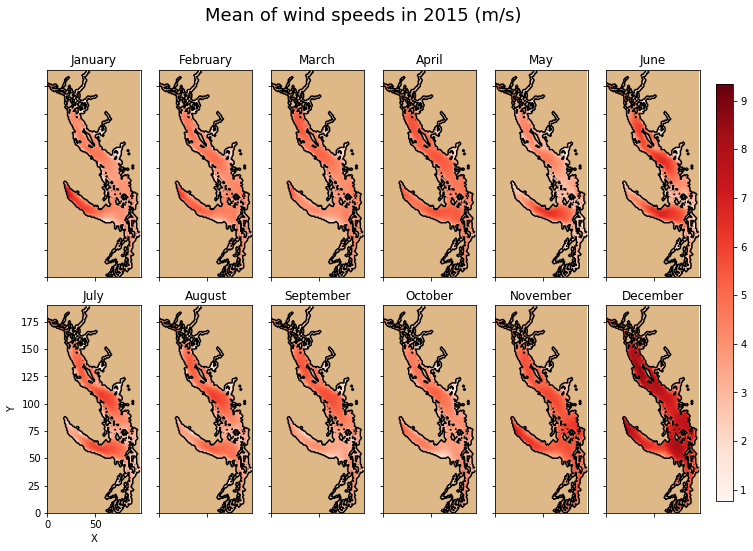

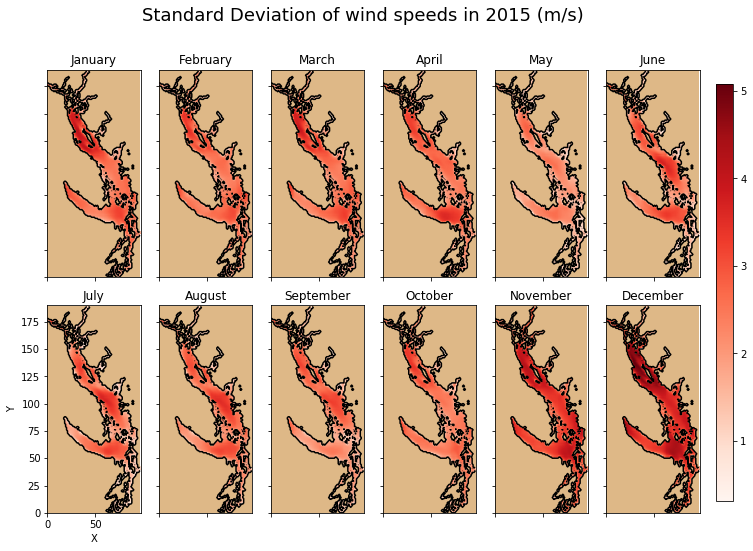

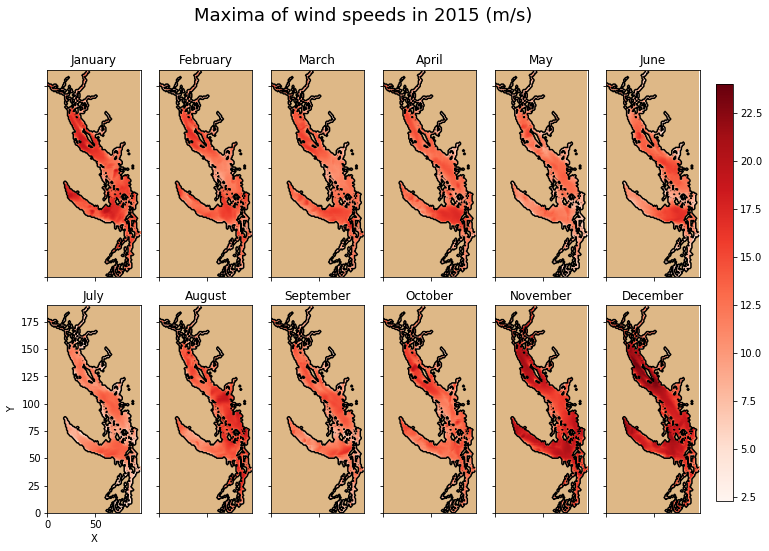

In [65]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/y2015_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder=2015, colormap='Reds')

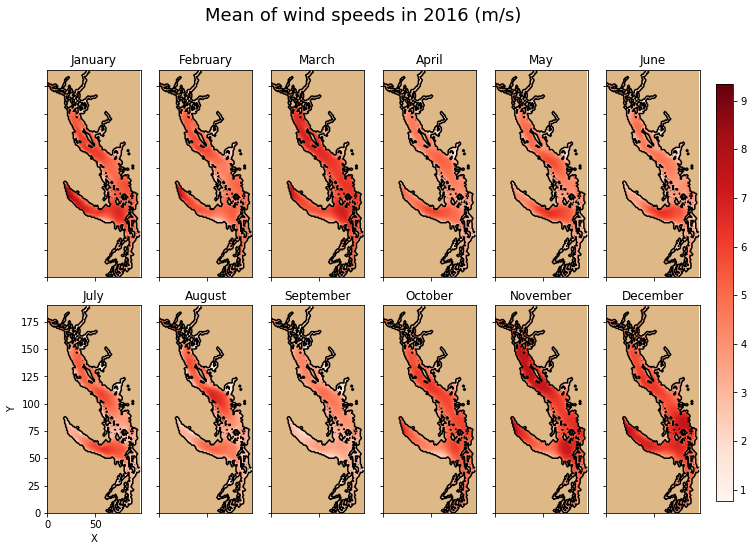

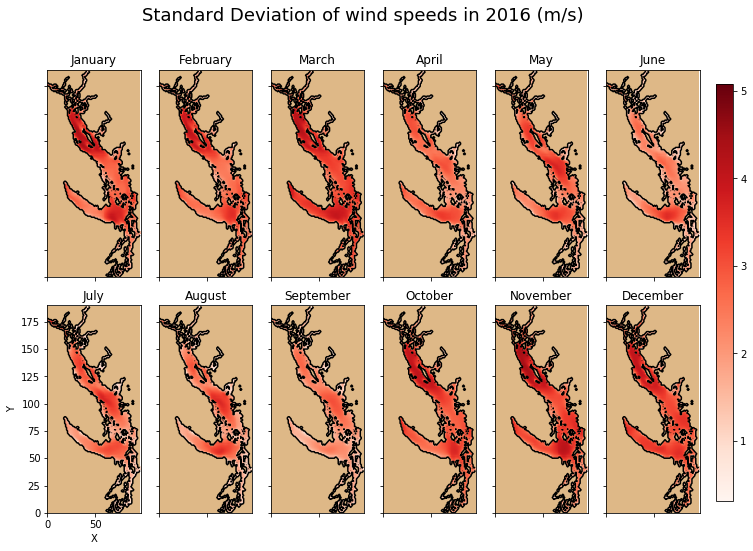

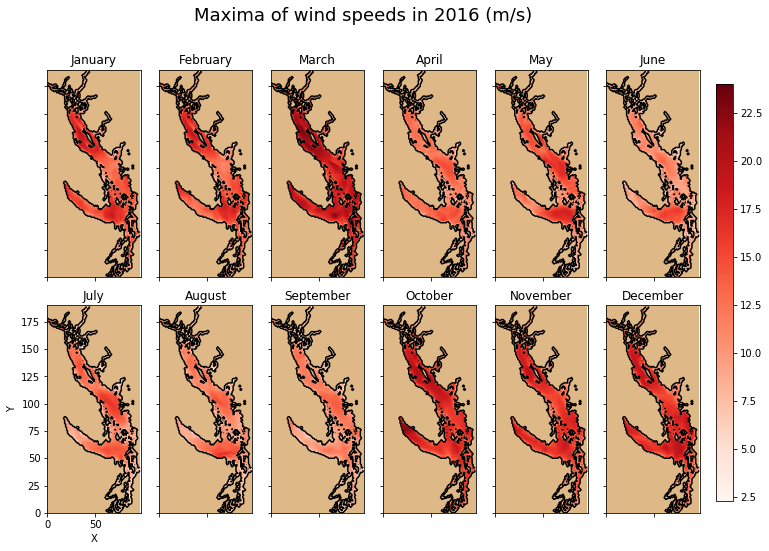

In [66]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/y2016_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder=2016, colormap='Reds')

In [32]:
print(mean_max)
print(mean_min) 
print(std_max)
print(std_min)
print(max_max)
print(max_min)
print(max_5)
print(min_5)
print(max_10)
print(min_10)

8.64602
0.9472403
5.0737963
0.3940021
23.46873
2.8618617
87.5
0.0
36.02150537634409
0.0


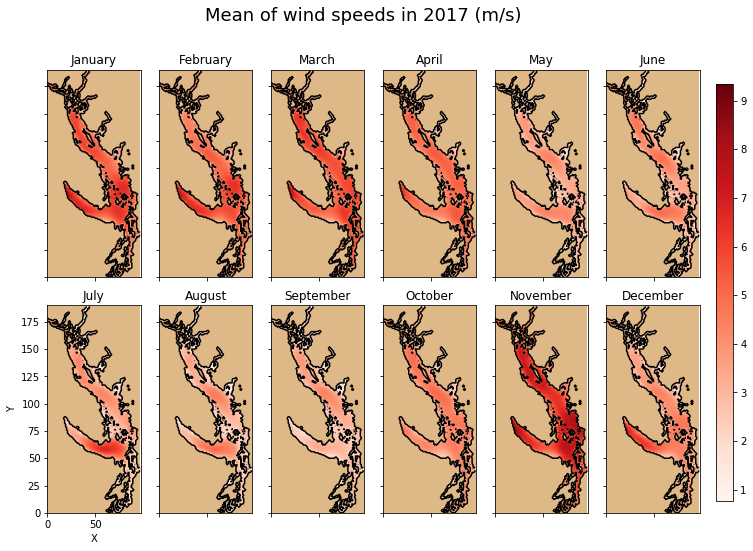

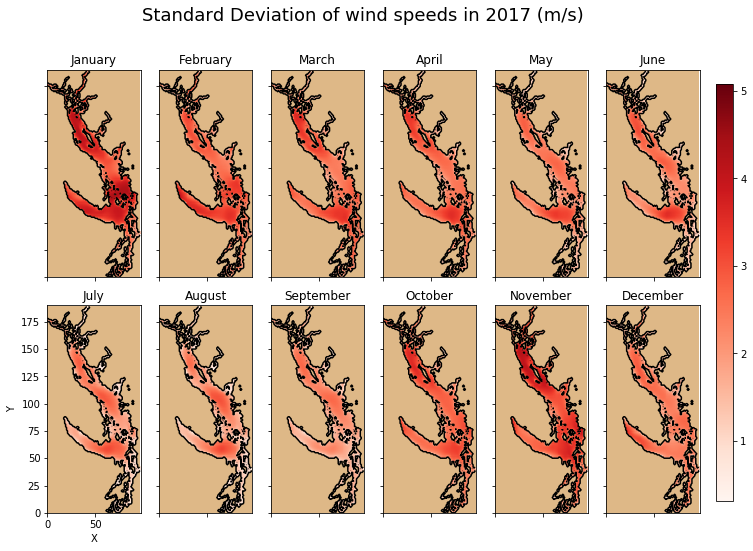

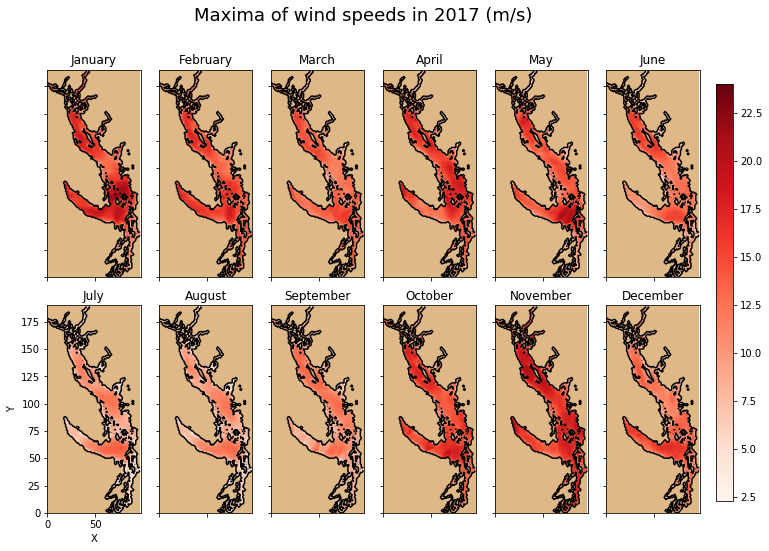

In [67]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/y2017_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder=2017, colormap='Reds')

In [34]:
print(mean_max)
print(mean_min) 
print(std_max)
print(std_min)
print(max_max)
print(max_min)
print(max_5)
print(min_5)
print(max_10)
print(min_10)

8.782202
0.7626688
5.0737963
0.35502413
23.46873
2.8265264
88.33333333333333
0.0
36.02150537634409
0.0


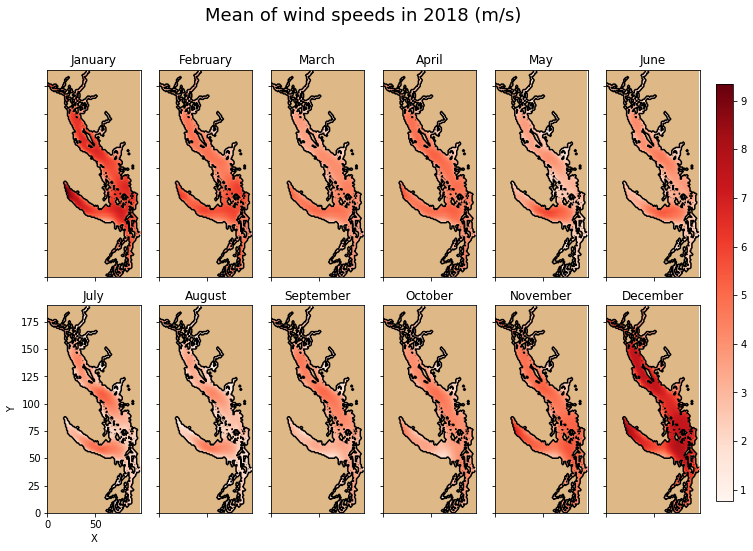

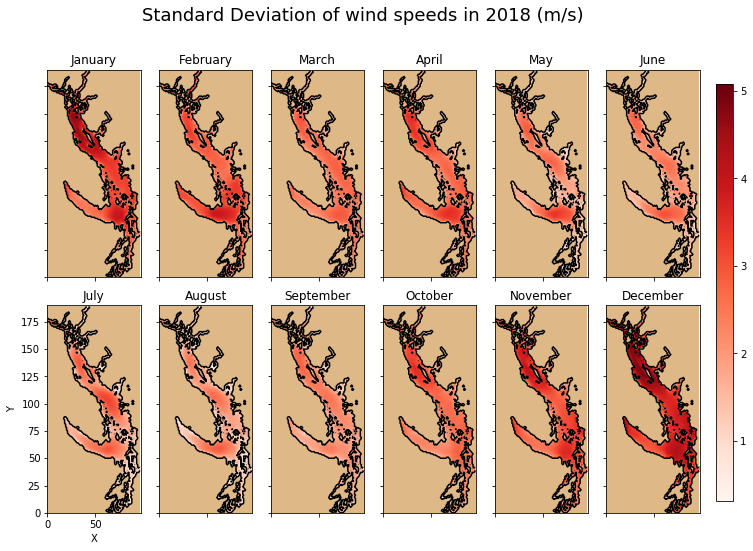

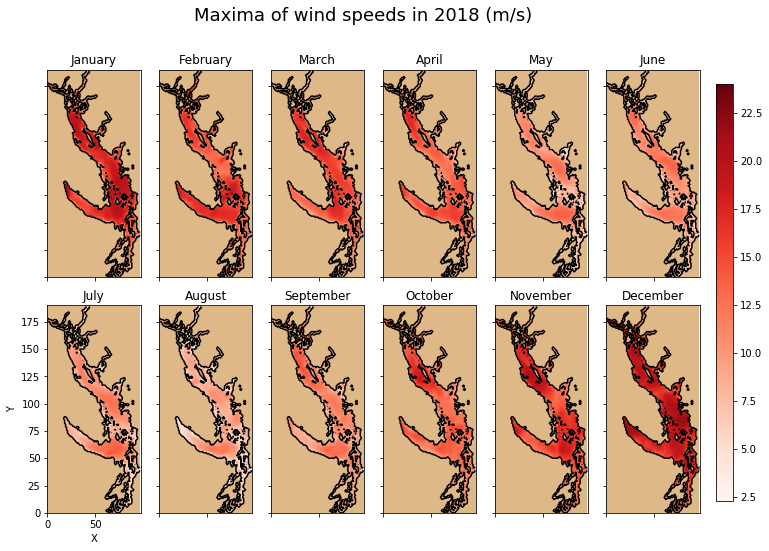

In [68]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/y2018_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder=2018, colormap='Reds')
dictionary_data = 0

In [55]:
print(mean_max)
print(mean_min) 
print(std_max)
print(std_min)
print(max_max)
print(max_min)
print(max_5)
print(min_5)
print(max_10)
print(min_10)

9.334371
0.7626688
5.0737963
0.31102356
24.005032
2.2897556
91.93548387096774
0.0
42.33870967741936
0.0


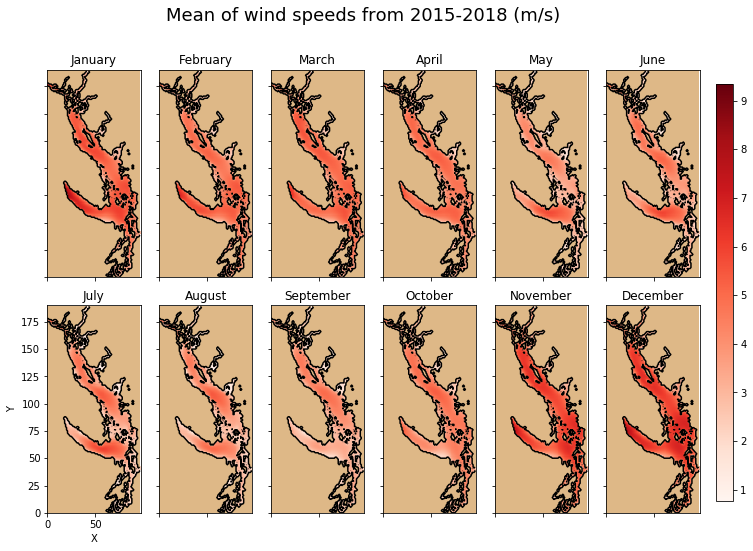

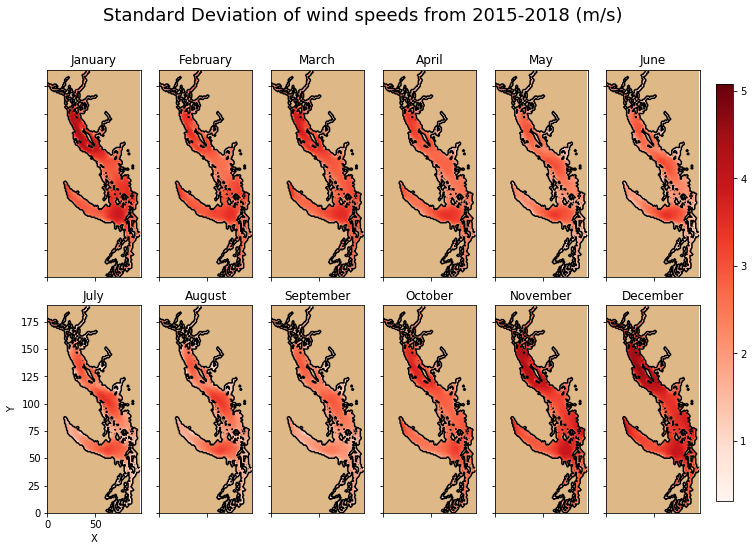

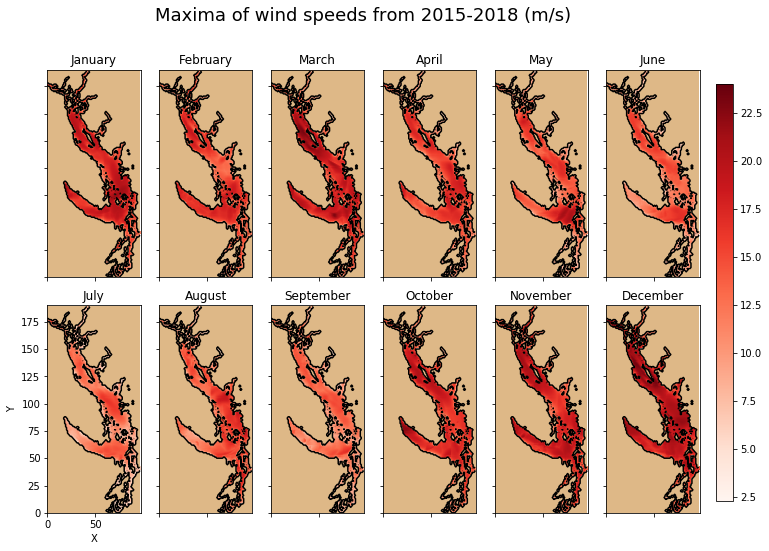

In [63]:
dictionary_data = 0
unpickle = open("/home/abhudia/Desktop/pickles/monthly_data.pickle", "rb")
dictionary_data = pickle.load(unpickle)
produce_plots2(names, abbr, operations, operation_names, thresholds, rows=2, cols=6, folder='all_data', colormap='Reds')

In [38]:
mean_max = 9.334371
mean_min= 0.7626688 
std_max = 5.0737963
std_min = 0.31102356
max_max = 24.005032
max_min = 2.2897556
max_5 = 91.93548387096774
min_5 = 0
max_10 = 42.33870967741936
min_10 = 0

9.334371
0.7626688
5.0737963
0.31102356
24.005032
2.2897556
91.93548387096774
0.0
42.33870967741936
0.0
